In [1]:
import os
import glob
import shutil

# Define the path to your dataset
dataset_path = "../dataset/MMAFEDB/train/"

# Define the emotions and their respective folders
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Loop through each emotion and remove all files containing '_augmented_'
for emotion in emotions:
    emotion_path = os.path.join(dataset_path, emotion)

    # Get a list of all files containing '_augmented_' in the emotion folder
    files_to_remove = glob.glob(os.path.join(emotion_path, '*_augmented_*'))

    # Remove each file
    for file_path in files_to_remove:
        os.remove(file_path)

    print(f'{emotion}: All files containing "_augmented_" removed successfully.')

    # Check if 'archive_images' folder is present
    archive_folder_path = os.path.join(emotion_path, 'archive_images')
    if os.path.exists(archive_folder_path):
        # Move contents of 'archive_images' to the parent folder
        files_in_archive = glob.glob(os.path.join(archive_folder_path, '*'))
        for file_in_archive in files_in_archive:
            destination_path = os.path.join(emotion_path, os.path.basename(file_in_archive))
            shutil.move(file_in_archive, destination_path)

        # Remove 'archive_images' folder
        os.rmdir(archive_folder_path)
        print(f'{emotion}: Contents of "archive_images" moved to parent folder.')

print("Cleanup completed.")


angry: All files containing "_augmented_" removed successfully.
disgust: All files containing "_augmented_" removed successfully.
fear: All files containing "_augmented_" removed successfully.
happy: All files containing "_augmented_" removed successfully.
happy: Contents of "archive_images" moved to parent folder.
neutral: All files containing "_augmented_" removed successfully.
neutral: Contents of "archive_images" moved to parent folder.
sad: All files containing "_augmented_" removed successfully.
sad: Contents of "archive_images" moved to parent folder.
surprise: All files containing "_augmented_" removed successfully.
Cleanup completed.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
import os
import glob
import pandas as pd

# Define the path to your dataset
dataset_path = "../dataset/MMAFEDB/train/"

# Define the emotions and their respective folders
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Specify the minimum number of images you want in each class after augmentation
min_images_per_class = 10000

# Create a DataFrame to store the image file paths and their corresponding labels
data = {'file_path': [], 'emotion': []}

for emotion in emotions:
    emotion_path = os.path.join(dataset_path, emotion)
    image_paths = glob.glob(os.path.join(emotion_path, '*.jpg'))
    data['file_path'].extend(image_paths)
    data['emotion'].extend([emotion] * len(image_paths))

df = pd.DataFrame(data)

# Dictionary to store the count of augmented images per emotion
augmented_count = {}

for emotion in emotions:
    augmented_count[emotion] = 0

# Create an ImageDataGenerator with your desired augmentation settings
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Loop through each emotion and perform augmentation
for emotion in emotions:
    # Filter the DataFrame to include only the current emotion
    subset_df = df[df['emotion'] == emotion]

    # Exclude previously augmented images from the DataFrame
    subset_df = subset_df[~subset_df['file_path'].str.contains('_augmented')]

    # Calculate the number of augmentations needed
    augmentations_needed = max(0, min_images_per_class - len(subset_df))

    # Create a flow_from_dataframe generator
    generator = datagen.flow_from_dataframe(
        subset_df,
        directory=None,  # We provide the full file paths in 'file_path' column
        x_col='file_path',
        y_col='emotion',
        target_size=(48, 48),
        batch_size=1,
        class_mode='categorical',
        save_to_dir=os.path.join(dataset_path, emotion),
        save_prefix=emotion + '_augmented',
        save_format='jpg'
    )

    # Generate augmented images only if augmentations are needed
    if augmentations_needed > 0:
        for i in range(augmentations_needed):
            batch = generator.next()

        # Get the count of augmented images generated
        augmented_count[emotion] = i + 1

        print(f'{emotion}: {augmented_count[emotion]} augmented images generated successfully.\n')
    else:
        print(f'{emotion}: 0 augmented images generated. No augmentations needed.\n')

# Print the total count of augmented images per emotion
print("\nTotal Augmented Images per Emotion:")
for emotion, count in augmented_count.items():
    print(f'{emotion}: {count}')


2024-02-02 18:25:12.902856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 18:25:13.785643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 6534 validated image filenames belonging to 1 classes.
angry: 3466 augmented images generated successfully.

Found 3227 validated image filenames belonging to 1 classes.
disgust: 6773 augmented images generated successfully.

Found 4830 validated image filenames belonging to 1 classes.
fear: 5170 augmented images generated successfully.

Found 28567 validated image filenames belonging to 1 classes.
happy: 0 augmented images generated. No augmentations needed.

Found 29338 validated image filenames belonging to 1 classes.
neutral: 0 augmented images generated. No augmentations needed.

Found 12182 validated image filenames belonging to 1 classes.
sad: 0 augmented images generated. No augmentations needed.

Found 8100 validated image filenames belonging to 1 classes.
surprise: 1900 augmented images generated successfully.


Total Augmented Images per Emotion:
angry: 3466
disgust: 6773
fear: 5170
happy: 0
neutral: 0
sad: 0
surprise: 1900


/home/fox/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


###########################
Folder: ../dataset/MMAFEDB/train/
Total Images: 110087

Count per emotion:
neutral: 29338
angry: 10000
fear: 10000
happy: 28567
disgust: 10000
sad: 12182
surprise: 10000

Count of Augmented Images per Emotion:
angry: 3466
fear: 5170
disgust: 6773
surprise: 1900


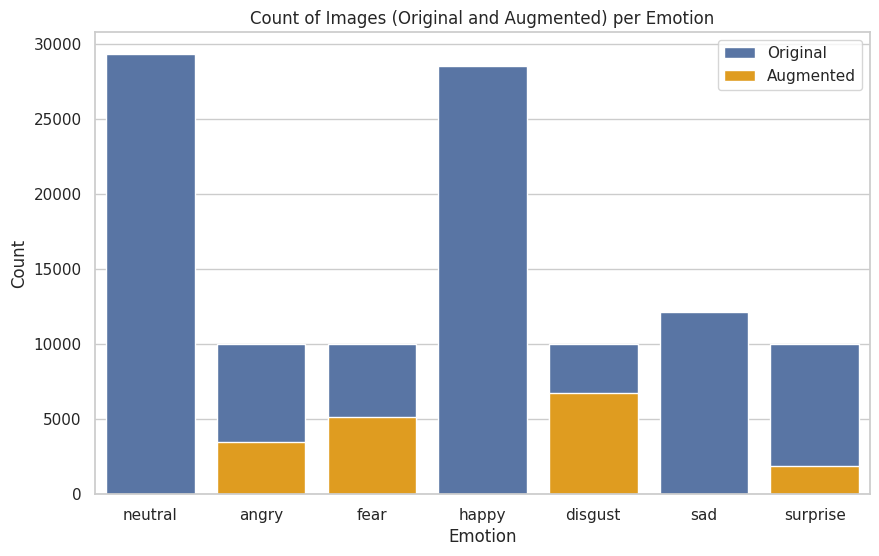

In [3]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

def summarize_images(folder, show_size_only=False):
    total_images = 0
    emotion_counts = {}
    augmented_counts = {}
    archive_folder_name = 'archive_images'

    for root, dirs, files in os.walk(folder):
        # Exclude 'archive_images' folder from processing
        dirs = [d for d in dirs if d != archive_folder_name]

        for file in files:
            if file.endswith(".jpg"):
                file_path = os.path.join(root, file)

                # Extract emotion from the path
                emotion = os.path.basename(os.path.dirname(file_path))

                total_images += 1

                # Skip 'archive_images' folder
                if emotion == archive_folder_name:
                    continue

                # Count per emotion
                if emotion in emotion_counts:
                    emotion_counts[emotion] += 1
                else:
                    emotion_counts[emotion] = 1

                # Count augmented images per emotion
                if "_augmented_" in file:
                    if emotion in augmented_counts:
                        augmented_counts[emotion] += 1
                    else:
                        augmented_counts[emotion] = 1

    print('###########################')
    print(f"Folder: {folder}")
    print(f"Total Images: {total_images}")

    print("\nCount per emotion:")
    for emotion, count in emotion_counts.items():
        print(f"{emotion}: {count}")

    print("\nCount of Augmented Images per Emotion:")
    for emotion, count in augmented_counts.items():
        print(f"{emotion}: {count}")

    # Plotting the stacked bar count using Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()), label="Original")
    sns.barplot(x=list(augmented_counts.keys()), y=list(augmented_counts.values()), label="Augmented", color='orange')
    plt.title("Count of Images (Original and Augmented) per Emotion")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    return {
        "total_images": total_images,
        "emotion_counts": emotion_counts,
        "augmented_counts": augmented_counts
    }

# Summarize images in the train folder
summary_train_dir = summarize_images(dataset_path)


In [4]:
import os
import shutil

def move_smallest_to_archive_per_emotion(folder, target_count=10000):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    archive_folder_name = 'archive_images'

    for emotion in emotions:
        emotion_folder = os.path.join(folder, emotion)

        # Check if the emotion folder exists
        if os.path.exists(emotion_folder):
            # List files in the emotion folder, sorted by size
            files_sorted_by_size = sorted(os.listdir(emotion_folder), key=lambda x: os.path.getsize(os.path.join(emotion_folder, x)))

            # Check if the emotion folder exceeds the target count
            count_to_move = max(0, len(files_sorted_by_size) - target_count)

            if count_to_move > 0:
                archive_emotion_folder = os.path.join(emotion_folder, archive_folder_name)

                # Create 'archive_images' folder inside the emotion folder if it doesn't exist
                if not os.path.exists(archive_emotion_folder):
                    os.makedirs(archive_emotion_folder)

                # Move files to 'archive_images' folder
                for file_to_move in files_sorted_by_size[:count_to_move]:
                    source_path = os.path.join(emotion_folder, file_to_move)
                    destination_path = os.path.join(archive_emotion_folder, file_to_move)
                    shutil.move(source_path, destination_path)

                print(f"Moved {count_to_move} smallest files to '{archive_folder_name}' folder in '{emotion}' emotion folder.")
            else:
                print(f"No files moved in '{emotion}' emotion folder as the count is within the target.")

        else:
            print(f"'{emotion}' emotion folder not found.")

# Example usage
move_smallest_to_archive_per_emotion(dataset_path)


No files moved in 'angry' emotion folder as the count is within the target.
No files moved in 'disgust' emotion folder as the count is within the target.
No files moved in 'fear' emotion folder as the count is within the target.
Moved 18567 smallest files to 'archive_images' folder in 'happy' emotion folder.
Moved 19338 smallest files to 'archive_images' folder in 'neutral' emotion folder.
Moved 2182 smallest files to 'archive_images' folder in 'sad' emotion folder.
No files moved in 'surprise' emotion folder as the count is within the target.


###########################
Folder: ../dataset/MMAFEDB/train/
Total Images: 110087

Count per emotion:
neutral: 10000
angry: 10000
fear: 10000
happy: 10000
disgust: 10000
sad: 10000
surprise: 10000

Count of Augmented Images per Emotion:
angry: 3466
fear: 5170
disgust: 6773
surprise: 1900


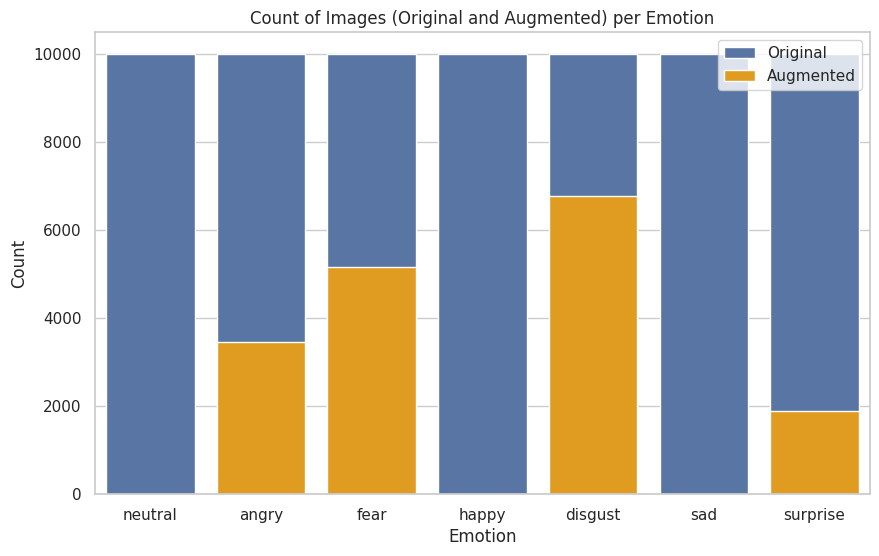

In [5]:
# Summarize images in the train folder
summary_train_dir = summarize_images(dataset_path)
